In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
import cPickle as pkl
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, r2_score, precision_recall_fscore_support
import common.metrics as met
import common.plots as plo
from common.h5py_loading import load_target_map, load_dataset
from common.h5py_data_loader import H5pyDataLoader
from common.prediction_analysis import df_from_chembl_export, intersect_truth_prediction
from lasagne_nn.run_nn import get_predictions_of_knowns, get_network_from_weights
from lasagne_nn.output_loader import df_from_prediction_path
import common.metrics as metrics
from scipy import interp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from textwrap import wrap

reload(plo)

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File 

<module 'common.plots' from '/srv/home/ecaceres/labgits/neural-nets/common/plots.pyc'>

In [2]:
# data handling

def get_env_var(handle):
    ''' Get an environment variable given the handle for the bash variable'''
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")

def get_preds(dset_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if dset_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
    return prediction, truth

def predictions_knowns_from_trained_network_and_data(hdf5_file, weights_filename, build_nn_script,
                                                     test_indices_file=None,
                                                     npKi=False, multitask=False,
                                                     network_target_map_file=None,
                                                     dataset_target_map_file=None):
    network = get_network_from_weights(weights_filename, build_nn=build_nn_script)
    network_target_map = load_target_map(network_target_map_file) if network_target_map_file else None
    data_loader = H5pyDataLoader(hdf5_file=hdf5_file, test_indices_file=test_indices_file,
                                 npKi=npKi, multitask=multitask,
                                 target_map_file=dataset_target_map_file,
                                 train_percentage=None)
    data_loader.load_training_data()
    predictions, knowns = get_predictions_of_knowns(data_loader=data_loader,
                                                    weights_filename=weights_filename,
                                                    indices=data_loader.train_indices,
                                                    network=network,
                                                    network_target_map=network_target_map)
    return predictions, knowns

In [3]:
reg_data_file = "./regression_preds_file_lookup.pkl"
with open(reg_data_file, "rb") as f:
    data_dict = pkl.load(f)

## plot ROC auc comparision between SMA, SEA-SMA, and STD w/scrambled baseline (FIGURE 2)

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Credit: Ian Hincks from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    try:
        c = mc.cnames[color]
    except:
        c = color

    c = colorsys.rgb_to_hls(*mc.colorConverter.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


In [24]:
def plot_k_folds(dset_dict, expt, dset, ax, plot_rand=False, threshold=6.0, ratio=None, x_y_type='tpr-fpr', 
                 color="red", amount=0.4, fontsize=24):
    first = True
    
    for fold in np.arange(0,5,1):
        prediction, truth = get_preds(dset_dict, expt, dset, fold, ratio=ratio)
        
        if dset != "drugmatrix":
            known_mask = ~np.isnan(truth)
            truth = truth[known_mask]
            prediction = prediction[known_mask]
        
        auc = plo.plot_binary_auc(prediction, truth, threshold=threshold, plot_rand=False, ax=ax, 
                                  x_y_type=x_y_type, show_legend=False, fontsize=fontsize,
                                  **{"color":lighten_color(color, amount=amount)})
        if first:
            preds = prediction
            truths = truth
            first = False
            
        else: 
            preds = np.hstack([preds, prediction])
            truths = np.hstack([truths, truth])

    return preds, truths


def plot_prc_comp(dset_dict, expt_list, dset, save_name=None, thresh=6.0, ratio=None, 
                  amount=0.5, big_lw=4, big_alpha=0.75, labelsize=30, titlesize=30, num_legend_columns=1, 
                  legend_bbox=(1,1), legend_fontsize="small", colors = sns.color_palette("deep", 8), title=None, legend_visible=False,
                 labelspacing=None, label_names=None, plot_random_labels=True, wrap_label_at=None, legend_frameon=False, plot_random_label=True, figsize=(11,11), markerfirst=True):
    plt.clf()
    sns.set_context("talk")
    sns.set(font_scale=2)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=figsize)
    color_counter = 0
    
    plotting_kwargs = {
        "plot_rand": False,
        "threshold" : thresh,
        "x_y_type" : "precision-recall",
    }
    
    concat_data = []
    
    for expt in expt_list:
        plotting_kwargs["color"] = colors[color_counter]
        if dset_dict[expt]["ratios"]:
            plot_ratio=ratio
        else:
            plot_ratio=None
            
        preds, truths = plot_k_folds(dset_dict, expt, dset, ax, 
                                              ratio=plot_ratio, amount = amount, **plotting_kwargs)
        concat_data.append((preds, truths, plotting_kwargs["color"], expt))
        color_counter += 1

    for i in np.arange(0,len(concat_data), 1):
        
        plotting_kwargs["color"] = concat_data[i][2]
        plotting_kwargs["linewidth"] = big_lw
        plotting_kwargs["alpha"] = big_alpha
        
        if i < len(concat_data)-1:
            plotting_kwargs["plot_rand"] = False
        else:
            plotting_kwargs["plot_rand"] = True
        auc = plo.plot_binary_auc(concat_data[i][0], concat_data[i][1], ax=ax, show_legend=False,  
                                  plot_label=concat_data[i][3], minimal_legend=True, **plotting_kwargs)
    
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=labelsize) 
    plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=labelsize) 
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)
    
  
    handles, labels = ax.get_legend_handles_labels()
    if plot_random_label:
        begin=-len(expt_list)-1
    else:
        begin=-len(expt_list)
    if label_names:
        tmp_labels = []
        for val, n in zip(labels[begin:], label_names):
            tmp_labels.append("{}: {}".format(n, val.split("(")[-1].split("= ")[-1].rstrip(")")))
        labels = tmp_labels
        labels = tmp_labels
    
    if wrap_label_at:
        labels = [ '\n'.join(wrap(l, wrap_label_at)) for l in labels]
        
    legend = pylab.legend(handles[-len(expt_list)-1:], labels[-len(expt_list)-1:], loc=2, 
                 fontsize=legend_fontsize,bbox_to_anchor=legend_bbox, ncol=num_legend_columns, markerfirst=markerfirst,
                          frameon=legend_frameon, handletextpad=0.5, labelspacing=labelspacing,).set_visible(legend_visible, )

    plt.tight_layout()
    if not title:
        title ="{} AUPRC (True Threshold: {})\n".format(dset.capitalize(), thresh)
    plt.title(title, size=titlesize)
    return plt, ax, legend
    

In [6]:
def inset_plot(dset_dict, expt_list, dset, save_name=None, thresh=6.0, ratio=None,
                  amount=0.5, big_lw=4, big_alpha=0.75, labelsize=30, titlesize=30, num_legend_columns=1, 
                  legend_bbox=(1,1), legend_fontsize="xsmall", ylim_min=0.7, colors = sns.color_palette("deep", 8),
              axins_width="80%", axins_height="70%", title=None, label_names=None, plot_random_label=True,
              legend_frameon=True, show_edges=True, columnspacing=None, figsize=(15,15), labelspacing=None,
              markerfirst=True, wrap_label_at=None):

    plt.clf()
    sns.set_context("talk")
    sns.set(font_scale=2)
    sns.set_style("white")
    plotting_kwargs = {
        "plot_rand": False,
        "threshold" : thresh,
        "x_y_type" : "precision-recall",
    }

    fig, ax, legend = plot_prc_comp(dset_dict, expt_list, dset, save_name=save_name, thresh=thresh, ratio=ratio, 
                            amount=amount, big_lw=big_lw, big_alpha=big_alpha, labelsize=labelsize, 
                            titlesize=titlesize, num_legend_columns=num_legend_columns, 
                            legend_bbox=legend_bbox, legend_fontsize=legend_fontsize, 
                            colors = colors, title=title, figsize=figsize, markerfirst=markerfirst, wrap_label_at=wrap_label_at)
    
    # axins controls the inset axes
    axins = inset_axes(ax, width=axins_width, height=axins_height, loc=8, 
                       bbox_to_anchor=(0,0.05,1,1), bbox_transform=ax.transAxes) 

    concat_data = []
    color_counter = 0
    
    for expt in expt_list: # this plots the k-folds for the inset
        plotting_kwargs.pop("linewidth", None)
        plotting_kwargs.pop("alpha", None)
        plotting_kwargs["color"] = colors[color_counter]
        if dset_dict[expt]["ratios"]:
            plot_ratio=ratio
        else:
            plot_ratio=None
        preds, truths = plot_k_folds(dset_dict, expt, dset, axins, 
                                              ratio=plot_ratio, amount = amount, **plotting_kwargs)
        concat_data.append((preds, truths, plotting_kwargs["color"], expt))
        color_counter += 1

    for i in np.arange(0,len(concat_data), 1): # this plots the mean values for the k-folds for the inset
        plotting_kwargs["color"] = concat_data[i][2]
        plotting_kwargs["linewidth"] = big_lw
        plotting_kwargs["alpha"] = big_alpha
        if i < len(concat_data)-1:
            plotting_kwargs["plot_rand"] = False
        else:
            plotting_kwargs["plot_rand"] = True
    
        auc2 = plo.plot_binary_auc(concat_data[i][0], concat_data[i][1], ax=axins, show_legend=False,  
                                  plot_label=concat_data[i][3], minimal_legend=True, **plotting_kwargs)
    for i in axins.lines:
        # mask with NaNs any point outside of ylim
        d = i.get_ydata() 
        mask = d < ylim_min
        d[mask] = np.nan
        i.set_ydata(d)
        
    # Hide the right and top spines
    axins.spines['right'].set_visible(show_edges)
    axins.spines['top'].set_visible(show_edges)

    # Only show ticks on the left and bottom spines
    axins.yaxis.set_ticks_position('left')
    axins.xaxis.set_ticks_position('bottom')
    axins.tick_params(labelright=False, labeltop=False)
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.tick_params(axis='x', which='both', bottom=True, top=False) 
    axins.tick_params(axis='y', which='both', left=True, right=False) 
    axins.xaxis.set_tick_params(labelsize=labelsize*.75)
    axins.yaxis.set_tick_params(labelsize=labelsize*.75)
    axins.set_ylim((ylim_min, 1))
    handles, labels = axins.get_legend_handles_labels()
    
    if plot_random_label:
        begin=-len(expt_list)-1
    else:
        begin=-len(expt_list)
    if label_names:
        tmp_labels = []
        for val, n in zip(labels[begin:], label_names):
            tmp_labels.append("{}: {}".format(n, val.split("(")[-1].split("= ")[-1].rstrip(")")))
        labels = tmp_labels
    else:
        labels = labels[begin:]
    
    if wrap_label_at:
        labels = [ '\n'.join(wrap(l, wrap_label_at)) for l in labels]
        
    legend = pylab.legend(handles[begin:], labels, loc="lower right", fontsize=legend_fontsize,
                 bbox_to_anchor=legend_bbox, ncol=num_legend_columns, frameon=legend_frameon, 
                          labelspacing=labelspacing, columnspacing=columnspacing, markerfirst=markerfirst, handletextpad=0.5)
    axins.set_title("")
    return


def plot_scrambled_differences(dset_dict, expt_list, d_set, save_name=None, thresh=6.0, ratio=None, 
                  amount=0.5, big_lw=4, big_alpha=0.75, labelsize=30, titlesize=40, num_legend_columns=1, 
                  legend_bbox=(1,1), legend_fontsize="small", colors = sns.color_palette("deep", 8), title=None,
                               plot_random_label=True, label_names=None, legend_visible=True, figsize=(10,10),
                              markerfirst=True, wrap_label_at=None):
    plt.clf()
    current_palette = sns.color_palette("deep")
    sns.set_palette(current_palette)
    sns.set_context("talk")
    sns.set(font_scale=2)
    sns.set_style("white")

    fig, ax = plt.subplots(figsize=figsize)   

    color_counter = 0
    
    plotting_kwargs = {
        "plot_rand": False,
        "threshold" : thresh,
        "x_y_type" : "precision-recall",
    }
    
    concat_data = []
    

    for expt in expt_list:
        plotting_kwargs["color"] = colors[color_counter]
        if dset_dict[expt]["ratios"]:
            plot_ratio=ratio
        else:
            plot_ratio=None

        preds, truths = plot_k_folds(dset_dict, expt, d_set, ax, 
                                              ratio=plot_ratio, amount = amount, **plotting_kwargs)
        concat_data.append((preds, truths, plotting_kwargs["color"], "{}".format(expt)))
        color_counter += 1

    for i in np.arange(0,len(concat_data), 1):
        
        plotting_kwargs["color"] = concat_data[i][2]
        plotting_kwargs["linewidth"] = big_lw
        plotting_kwargs["alpha"] = big_alpha
        
        if i < len(concat_data)-1:
            plotting_kwargs["plot_rand"] = False
        else:
            plotting_kwargs["plot_rand"] = True
        auc = plo.plot_binary_auc(concat_data[i][0], concat_data[i][1], ax=ax, show_legend=False,  
                                  plot_label=concat_data[i][3], minimal_legend=True, **plotting_kwargs)
    
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)
    
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=labelsize) 
    plt.tick_params(axis='y', which='both', left=True, right=False, labelsize=labelsize) 
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)
    
    handles, labels = ax.get_legend_handles_labels()
    
    if plot_random_label:
        begin=-len(expt_list)-1
    else:
        begin=-len(expt_list)
    if label_names:
        tmp_labels = []
        for val, n in zip(labels[begin:], label_names):
            tmp_labels.append("{}: {}".format(n, val.split("= ")[-1].rstrip(")")))
        labels = tmp_labels
    else:
        labels = labels[begin:]
        
    if wrap_label_at:
        labels = [ '\n'.join(wrap(l, wrap_label_at)) for l in labels]
        
    legend = pylab.legend(handles[begin:], labels, loc="lower right", fontsize=legend_fontsize,
                 bbox_to_anchor=legend_bbox, ncol=num_legend_columns, frameon=False, markerfirst=markerfirst, handletextpad=0.5).set_visible(legend_visible)
    
    plt.tight_layout()
    if not title:
        title="{} AUPRC (True Threshold: {})\n".format(d_set.capitalize(), thresh)
    plt.title(title, size=titlesize)
    return fig, ax, legend

def inset_plot_scrambled(dset_dict, expt_list, dset, save_name=None, thresh=6.0, ratio=None,
                  amount=0.5, big_lw=4, big_alpha=0.75, labelsize=20, titlesize=30, num_legend_columns=1, 
                  legend_bbox=(1,1), legend_fontsize="small", ylim_min=0.7, ylim_max=1.0, colors = sns.color_palette("deep", 8),
              axins_width="80%", axins_height="70%", inset_loc=8, inset_y_offset=1, title=None, label_names=None,
                   plot_random_label=True, legend_frameon=True, show_edges=True, inset_x_offset=0, figsize=(10, 10),
                        markerfirst=True):
    plt.clf()
    sns.set_context("poster")
    sns.set(font_scale=2)
    sns.set_style("white")
    plotting_kwargs = {
        "plot_rand": False,
        "threshold" : thresh,
        "x_y_type" : "precision-recall",
    }

    fig, ax, legend = plot_scrambled_differences(dset_dict, expt_list, dset, save_name=save_name, thresh=thresh, ratio=ratio, 
                            amount=amount, big_lw=big_lw, big_alpha=big_alpha, labelsize=labelsize, 
                            titlesize=titlesize, num_legend_columns=num_legend_columns, 
                            legend_bbox=legend_bbox, legend_fontsize=legend_fontsize, figsize=figsize,
                            colors = colors, title=title, label_names=label_names, legend_visible=False)
    
    # axins controls the inset axes
    axins = inset_axes(ax, width=axins_width, height=axins_height, loc=inset_loc, 
                       bbox_to_anchor=(inset_x_offset*0.05,inset_y_offset*0.05,1,1), bbox_transform=ax.transAxes) 

    concat_data = []
    color_counter = 0
    
    for expt in expt_list: # this plots the k-folds for the inset
        plotting_kwargs.pop("linewidth", None)
        plotting_kwargs.pop("alpha", None)
        plotting_kwargs["color"] = colors[color_counter]
        if dset_dict[expt]["ratios"]:
            plot_ratio=ratio
        else:
            plot_ratio=None
        preds, truths = plot_k_folds(dset_dict, expt, dset, axins, 
                                              ratio=plot_ratio, amount = amount, **plotting_kwargs)
        concat_data.append((preds, truths, plotting_kwargs["color"], expt))
        color_counter += 1

    for i in np.arange(0,len(concat_data), 1): # this plots the mean values for the k-folds for the inset
        plotting_kwargs["color"] = concat_data[i][2]
        plotting_kwargs["linewidth"] = big_lw
        plotting_kwargs["alpha"] = big_alpha
        if i < len(concat_data)-1:
            plotting_kwargs["plot_rand"] = False
        else:
            plotting_kwargs["plot_rand"] = True
    
        auc2 = plo.plot_binary_auc(concat_data[i][0], concat_data[i][1], ax=axins, show_legend=False,  
                                  plot_label=concat_data[i][3], minimal_legend=True, **plotting_kwargs)
    for i in axins.lines:
        # mask with NaNs any point outside of ylim
        d = i.get_ydata() 
        mask1 = d < ylim_min
        mask2 = d > ylim_max
        d[mask1|mask2] = np.nan
        i.set_ydata(d)
        
    # Hide the right and top spines
    axins.spines['right'].set_visible(show_edges)
    axins.spines['top'].set_visible(show_edges)

    # Only show ticks on the left and bottom spines
    axins.yaxis.set_ticks_position('left')
    axins.xaxis.set_ticks_position('bottom')

    axins.tick_params(labelright=False, labeltop=False)
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.tick_params(axis='x', which='both', bottom=True, top=False) 
    axins.tick_params(axis='y', which='both', left=True, right=False) 
    axins.xaxis.set_tick_params(labelsize=labelsize*.75)
    axins.yaxis.set_tick_params(labelsize=labelsize*.75)
    axins.set_ylim((ylim_min, ylim_max))
    
    handles, labels = axins.get_legend_handles_labels()
    
    if plot_random_label:
        begin=-len(expt_list)-1
    else:
        begin=-len(expt_list)
    if label_names:
        tmp_labels = []
        for val, n in zip(labels[begin:], label_names):
            tmp_labels.append("{}: {}".format(n, val.split("(")[-1].split("= ")[-1].rstrip(")")))
        labels = tmp_labels
    else:
        labels = labels[begin:]
        
    legend = pylab.legend(handles[begin:], labels, loc="lower right", fontsize=legend_fontsize,
                 bbox_to_anchor=legend_bbox, ncol=num_legend_columns, frameon=legend_frameon, markerfirst=markerfirst, handletextpad=0.5)
    axins.set_title("")
    return


In [7]:
with open("./color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("./color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)

In [8]:
expt_legend_lookup = {
"NEG_RM": "Negatives Removed",
"NEG_UW" : "Negatives Upweighted",
"STD": "STD",
"NEG_RM_SMA": "Negatives Removed +SNA",
"STD_SMA": "SNA",
"scrambled_idx_LC": "SNA scrambled",
"SEA_SMA": "SNA +SEA blacklist",
"scrambled_idx_no_SMA_LC": "STD scrambled",
"CLASSIFIER_SEA_SMA": "SNA +SEA blacklist (classifier)",
"CLASSIFIER_NEG_RM_SMA_RATIOS":  "Negatives Removed +SNA (classifier)",
"CLASSIFIER_SMA_RATIOS": "SNA (classifier)",
"CLASSIFIER_scrambled_idx_LC": "SNA scrambled (classifier)",
"CLASSIFIER_scrambled_idx_No_SMA_LC": "STD scrambled (classifier)",
"CLASSIFIER_STD": "STD (classifier)", 
"NEG_RM_scrambled": "Negatives Removed scrambled", 
"NEG_RM_RATIOS_scrambled": "Negatives Removed +SNA scrambled",
'CLASSIFIER_NEG_RM_scrambled' : "Negatives Removed scrambled (classifier)",
'CLASSIFIER_NEG_RM_RATIOS_scrambled': "Negatives Removed +SNA scrambled (classifier)",
'CLASSIFIER_NEG_RM': 'Negatives Removed (classifier)', 
'CLASSIFIER_SEA_SMA': 'SNA +SEA blacklist (classifier)'}

# Threshold = 5.0

In [38]:
save_dir = "{}/final_paper_figs".format(get_env_var("HOME"))
sns.set_context("poster")
figsize_all = (13, 13)
labelsize_all = 35
titlesize_all = 40
legend_fontsize_all = 30
markerfirst=True

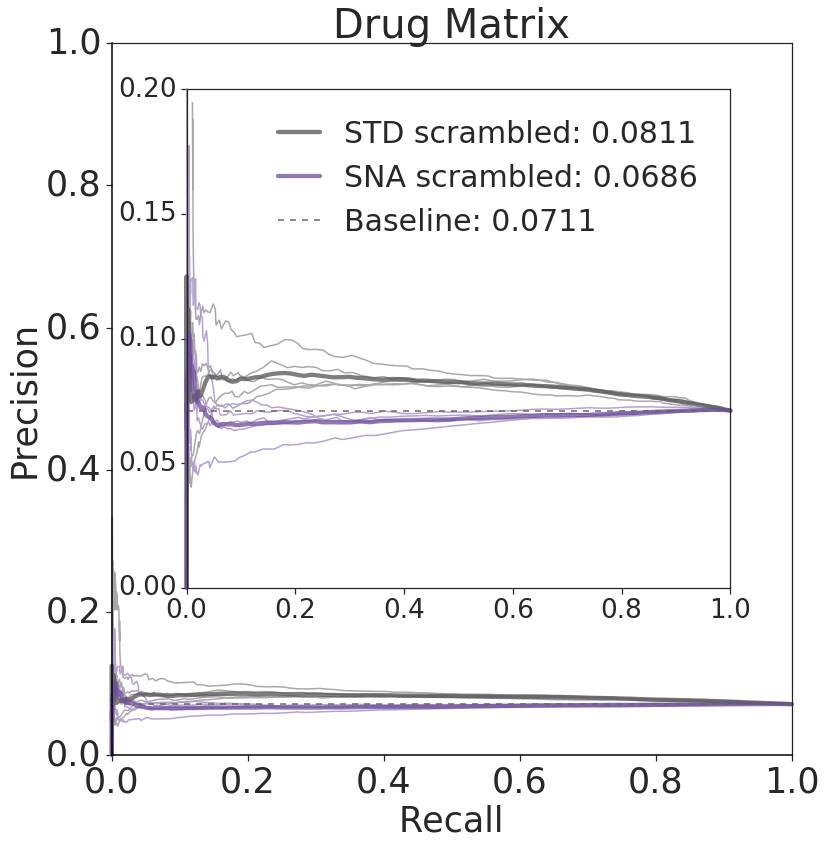

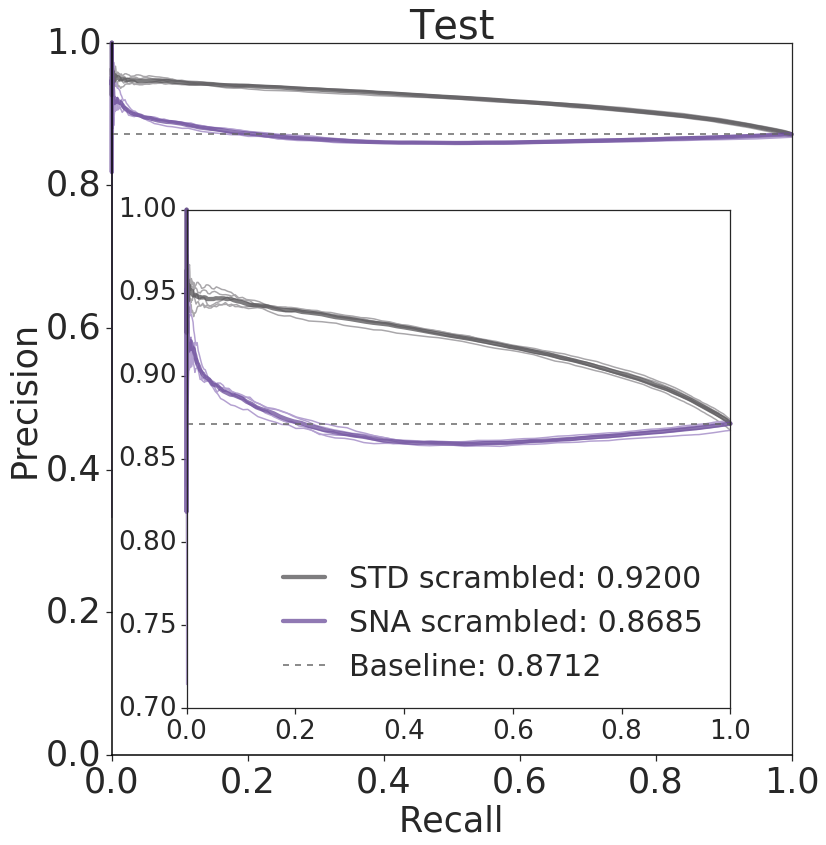

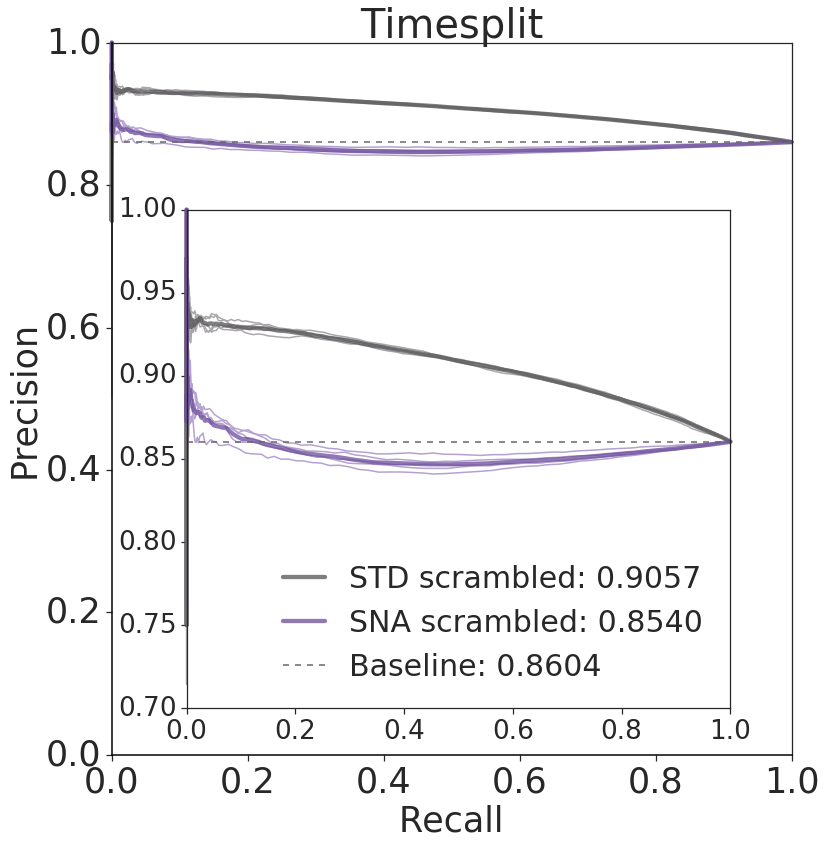

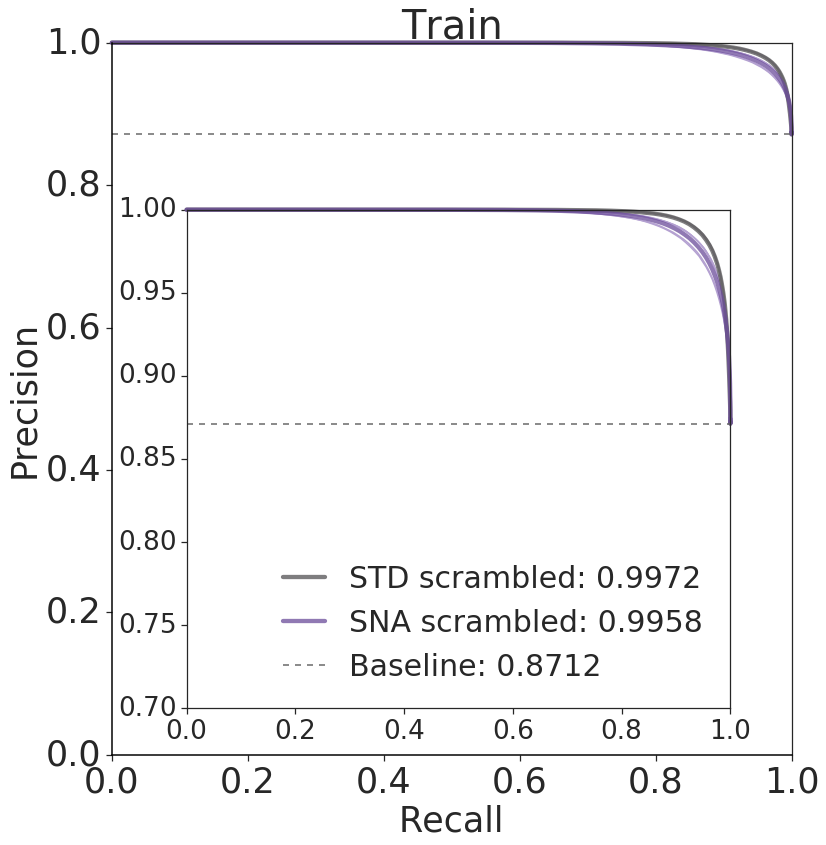

In [ ]:
expt_order = ["scrambled_idx_no_SMA", "scrambled_idx"]
tmp_colors = [color_dict_pt[i] for i in expt_order]
tmp_colors.extend([color_dict_bar[i] for i in expt_order])
expt_order = ["scrambled_idx_no_SMA_LC", "scrambled_idx_LC"]

plotting_kwargs = {
    "save_name":None,
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4.3,
    "num_legend_columns":1,
    "legend_bbox":(0.99, 0.65),
    "legend_fontsize": legend_fontsize_all,
    "ylim_min" : 0.,
    "ylim_max" : 0.2,
    "inset_loc" : 9,
    "inset_y_offset" : -1,
    "inset_x_offset" : 0.2,
    "colors" : tmp_colors,
    "legend_frameon" : False,
    "labelsize" : labelsize_all,
    "figsize" : figsize_all, 
    "titlesize" : titlesize_all,
    "markerfirst" : markerfirst,
}

label_names = ["STD scrambled", "SNA scrambled", "Baseline"]
inset_plot_scrambled(data_dict, expt_order, "drugmatrix", title="Drug Matrix", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/scrambled_drugmatrix_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

plotting_kwargs["ylim_min"] = 0.7
plotting_kwargs["ylim_max"] = 1.0
plotting_kwargs["inset_loc"] = 8
plotting_kwargs["inset_y_offset"] = 1
plotting_kwargs["legend_bbox"]=(1,0)

inset_plot_scrambled(data_dict, expt_order, "test", title="Test", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/scrambled_test_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()
inset_plot_scrambled(data_dict, expt_order, "timesplit", title="Timesplit", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/scrambled_timesplit_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()
inset_plot_scrambled(data_dict, expt_order, "train", title="Train", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/scrambled_train_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

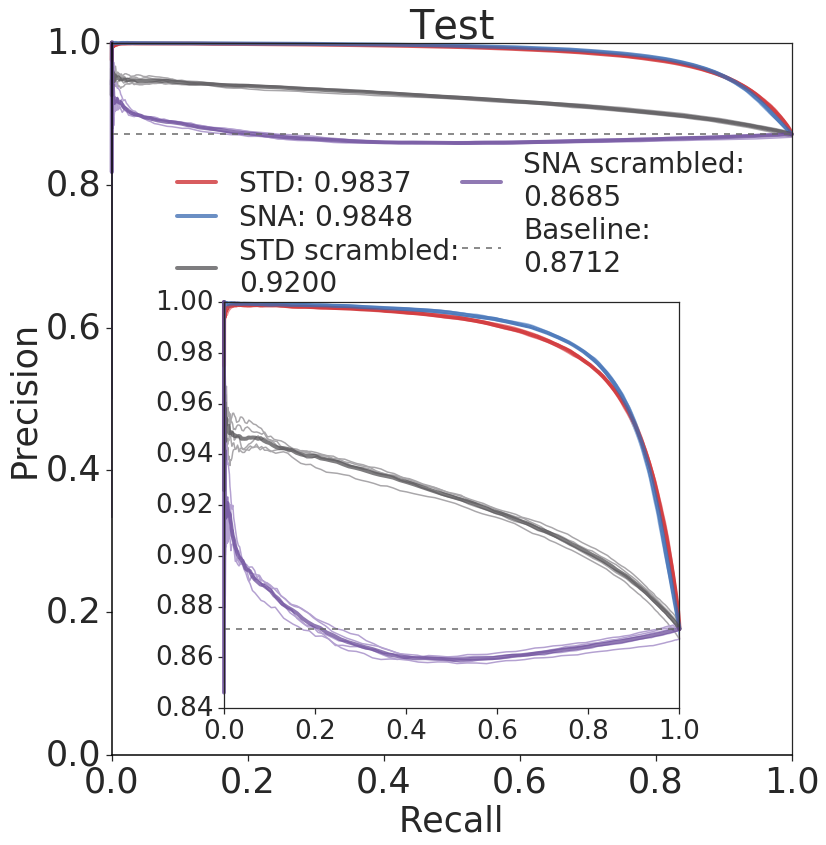

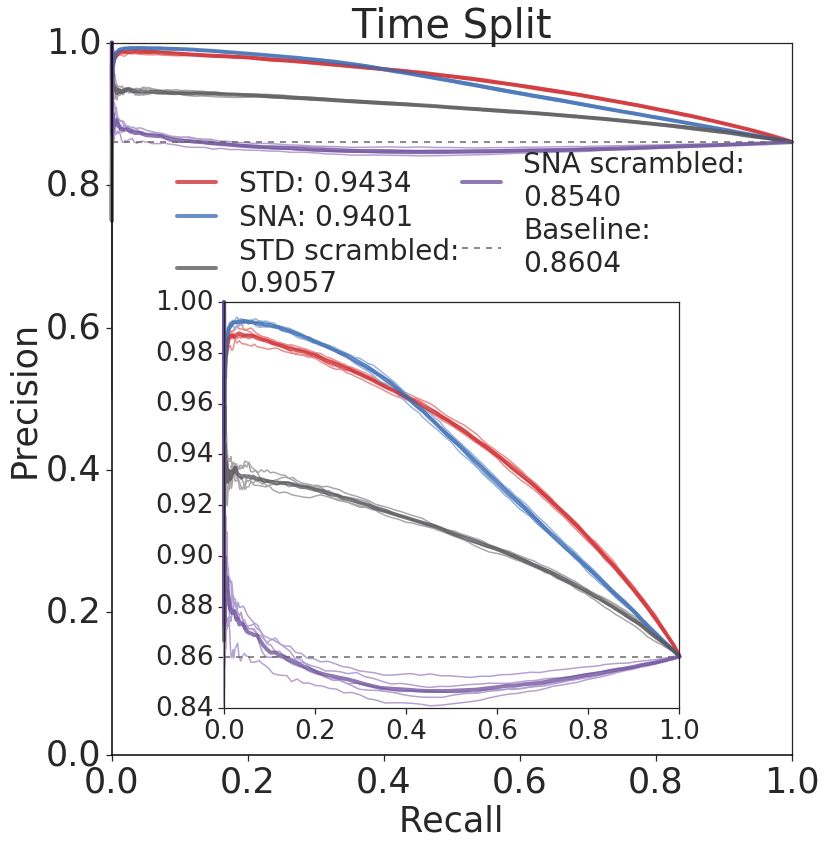

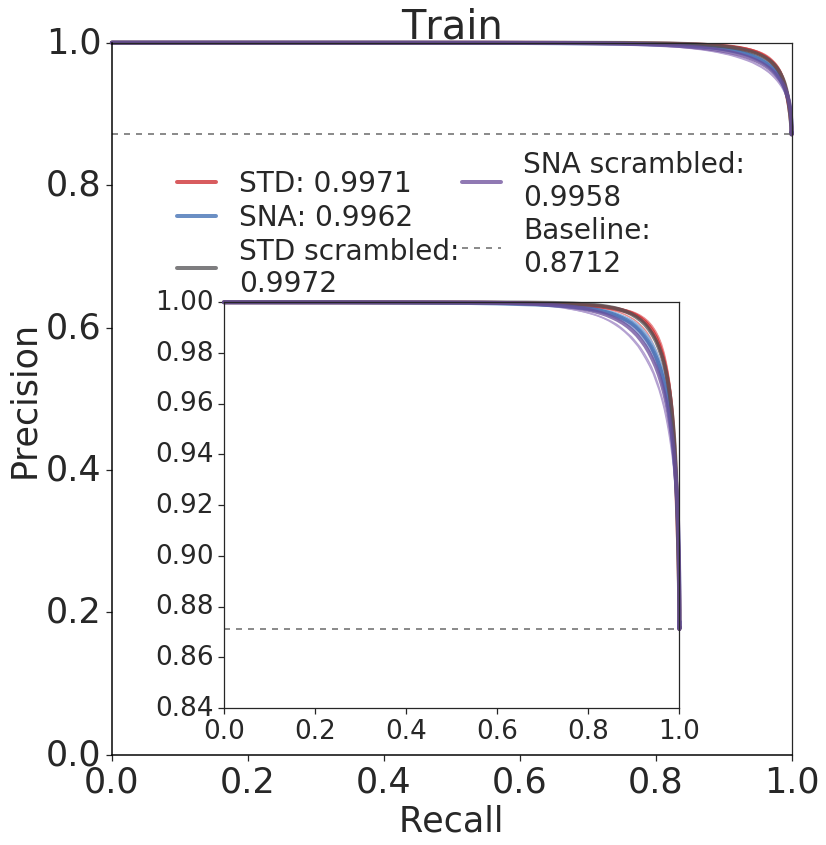

In [15]:
legend_fontsize_all = 28

expt_order = ["STD", "STD_SMA",  "scrambled_idx_no_SMA", "scrambled_idx", ]
plotting_kwargs = {
    "save_name":None,
    "axins_width": "67%",
    "axins_height": "57%",
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4,
    "num_legend_columns":2,
    "legend_bbox":(0,0),
    "legend_fontsize":18,
    "ylim_min" : 0.84,
    "colors" : [color_dict_pt[i] for i in expt_order],
    "legend_frameon" : False,
    "legend_bbox" : (1.2,0.95),
    "labelsize" : labelsize_all,
    "figsize" : figsize_all, 
    "titlesize" : titlesize_all,
    "legend_fontsize": legend_fontsize_all,
    "columnspacing" : -0.2,
    "markerfirst": True,
    "labelspacing" : 0.2,
    "wrap_label_at": 15,
}

expt_order = ["STD", "STD_SMA",  "scrambled_idx_no_SMA_LC", "scrambled_idx_LC", ]
label_names=["STD", "SNA", "STD scrambled", "SNA scrambled", "Baseline"]
inset_plot(data_dict, expt_order, "test", title="Test", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/test_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

plt.show()
inset_plot(data_dict, expt_order, "timesplit", title="Time Split",label_names=label_names, **plotting_kwargs)
plt.savefig("{}/timesplit_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

inset_plot(data_dict, expt_order, "train", title="Train", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/train_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

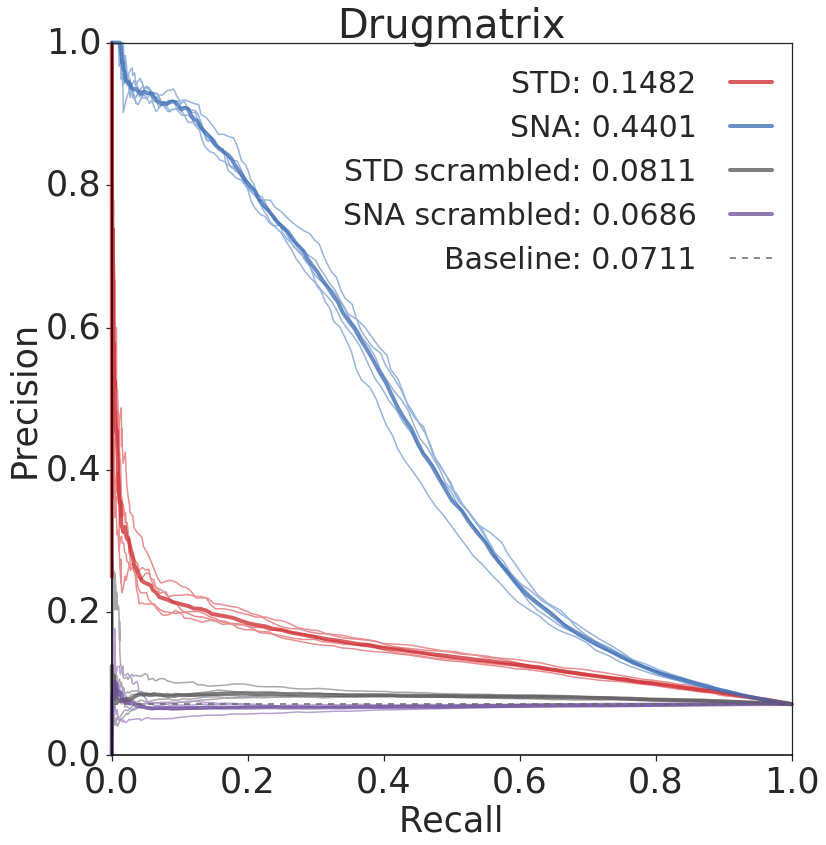

In [20]:
legend_fontsize_all=30

expt_order = ["STD", "STD_SMA",  "scrambled_idx_no_SMA", "scrambled_idx", ]
plotting_kwargs = {
    "save_name":None,
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4,
    "num_legend_columns":1,
    "legend_fontsize": legend_fontsize_all,
    "colors" : [color_dict_pt[i] for i in expt_order],    
    "legend_frameon" : False,
    "legend_bbox" : (0.3,1),
    "legend_visible" : True,
    "labelsize" : labelsize_all,
    "figsize" : figsize_all, 
    "titlesize" : titlesize_all,
    "legend_fontsize": legend_fontsize_all,
    "markerfirst": False,
    
}
sns.set_context("talk")
expt_order = ["STD", "STD_SMA",  "scrambled_idx_no_SMA_LC", "scrambled_idx_LC", ]
label_names=["STD", "SNA", "STD scrambled", "SNA scrambled", "Baseline"]

plot_prc_comp(data_dict, expt_order, "drugmatrix", title="Drugmatrix", label_names = label_names, **plotting_kwargs)
plt.savefig("{}/drugmatrix_regression_AUPRCs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

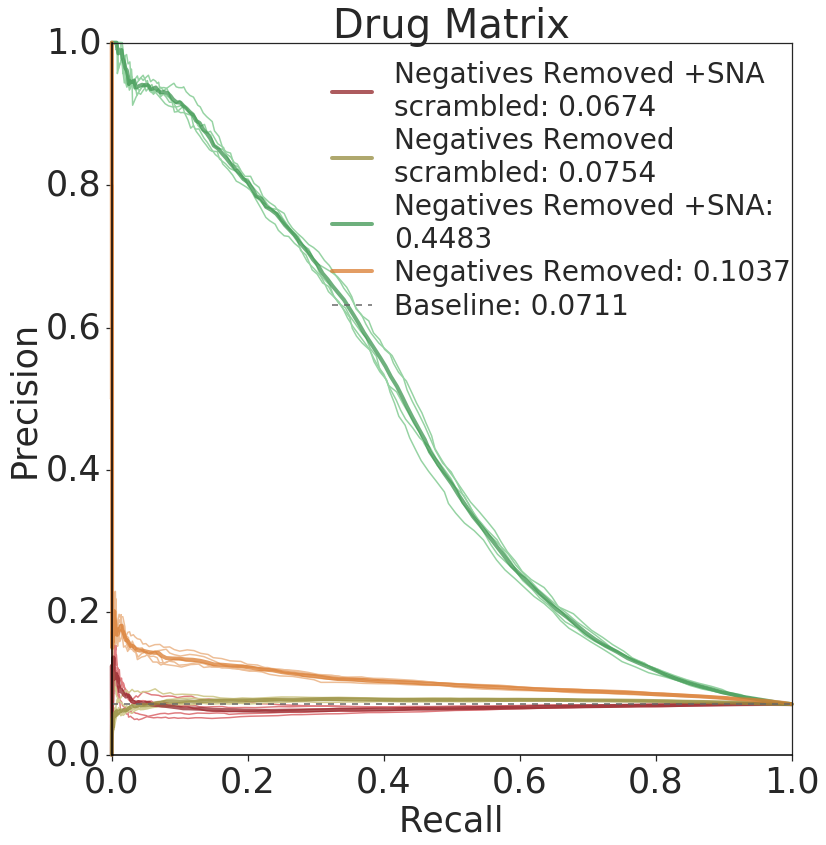

In [36]:
legend_fontsize_all=28
expt_order = ["NEG_UW", "SEA_SMA", "NEG_RM_SMA","NEG_RM",   ]

plotting_kwargs = {
    "save_name":None,
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4,
    "num_legend_columns":1,
    "legend_fontsize":legend_fontsize_all,
    "colors" : [color_dict_pt[i] for i in expt_order],    
    "legend_frameon" : False,
    "legend_bbox" : (0.275,1.01),
    "legend_visible" : True,
    "labelsize" : labelsize_all,
    "figsize" : figsize_all, 
    "titlesize" : titlesize_all,
    "legend_fontsize": legend_fontsize_all,
    "markerfirst": True,
    "wrap_label_at" : 27,
    "labelspacing" : 0.2,
}
sns.set_context("talk")
expt_order = ["NEG_RM_RATIOS_scrambled", "NEG_RM_scrambled", "NEG_RM_SMA", "NEG_RM",   ]
label_names = [expt_legend_lookup[i] for i in expt_order]
label_names.append("Baseline")
plot_prc_comp(data_dict, expt_order, "drugmatrix", title="Drug Matrix", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/drugmatrix_regression_AUPRC_NEGRMs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()


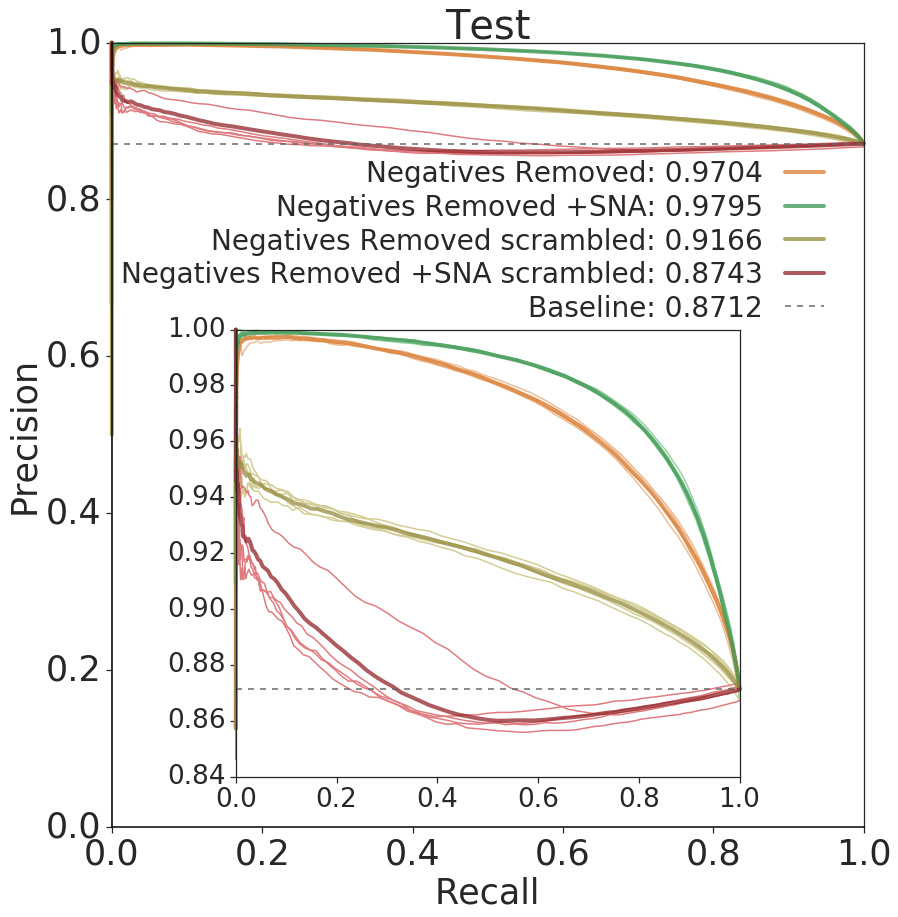

In [ ]:
expt_order = ["NEG_RM", "NEG_RM_SMA",  "SEA_SMA", "NEG_UW", ] #hack for different colors

plotting_kwargs = {
    "save_name":None,
    "axins_width": "67%",
    "axins_height": "57%",
    "thresh": 5.0,
    "ratio":"1.0",
    "amount":0.5,
    "big_lw":4,
    "num_legend_columns":1,
    "legend_bbox":(0,0),
    "legend_fontsize":18,
    "ylim_min" : 0.84,
    "colors" : [color_dict_pt[i] for i in expt_order],
    "legend_frameon" : False,
    "legend_bbox" : (1.235,0.96),
    "labelsize" : labelsize_all,
    "figsize" : figsize_all, 
    "titlesize" : titlesize_all,
    "legend_fontsize":legend_fontsize_all-2,
    "labelspacing": .2,
    "markerfirst" : False,
}

expt_order = ["NEG_RM", "NEG_RM_SMA",  "NEG_RM_scrambled", "NEG_RM_RATIOS_scrambled", ]
label_names = [expt_legend_lookup[i] for i in expt_order]
# label_names = [ '\n'.join(wrap(l, 25)) for l in label_names]
label_names.append("Baseline")

inset_plot(data_dict, expt_order, "test", title="Test",  label_names=label_names, **plotting_kwargs)
plt.savefig("{}/test_regression_AUPRC_NEGRMs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

inset_plot(data_dict, expt_order, "timesplit", title="Time Split", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/timesplit_regression_AUPRC_NEGRMs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()

inset_plot(data_dict, expt_order, "train", title="Train", label_names=label_names, **plotting_kwargs)
plt.savefig("{}/train_regression_AUPRC_NEGRMs.png".format(save_dir), dpi=300)
plt.show()
plt.clf()